In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [13]:
def display_gen_pred(imgs, size=(1, 28, 28)):
    img_unflat = imgs.detach().cpu().view(-1, *size)
    img_grid = make_grid(img_unflat[:25], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()
    
def display_loss_plot(gen_loss, disc_loss):
    plt.plot(range(len(disc_loss)), disc_loss, label='Critic loss')
    plt.plot(range(len(gen_loss)), gen_loss, label='Generator loss')
    plt.legend()
    plt.show()

# Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, z_chan=10, img_chan=1, h_chan=64, device='cpu'):
        super(Generator, self).__init__()
        
        self.z_chan = z_chan
        self.device = device
        self.gen = nn.Sequential(
            self.layer(z_chan, h_chan*4),
            self.layer(h_chan*4, h_chan*2, kernel_size=4, stride=1),
            self.layer(h_chan*2, h_chan),
            self.layer(h_chan, img_chan, kernel_size=4, last_layer=True)
        )

    def layer(self, in_chan, out_chan, kernel_size=3, stride=2, last_layer=False):
        if not last_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_chan, out_chan, kernel_size, stride),
                nn.BatchNorm2d(out_chan),
                nn.ReLU(),
            )
        return nn.Sequential(
            nn.ConvTranspose2d(in_chan, out_chan, kernel_size, stride),
            nn.Tanh(),
        )

    def forward(self, noise):
        noise = noise.view(len(noise), self.z_chan, 1, 1)
        return self.gen(noise)

    def get_imgs(self, n_imgs):
        noise = self.get_noise(n_imgs)
        return self(noise)

    def get_noise(self, n_samples):
        return torch.randn(n_samples, self.z_chan, device=self.device)

# Critic

In [4]:
class Critic(nn.Module):
    def __init__(self, img_chan=1, h_chan=16, device='cpu'):
        super(Critic, self).__init__()

        self.device = device
        self.crit = nn.Sequential(
            self.layer(img_chan, h_chan),
            self.layer(h_chan, h_chan*2),
            self.layer(h_chan*2, 1, last_layer=True),
        )
        
    def get_gradient(self, real_img, fake_img, epsilon):
        mixed_img = epsilon*real_img + (1-epsilon)*fake_img
        score = self(mixed_img)

        gradient = torch.autograd.grad(
            inputs=mixed_img,
            outputs=score,
            grad_outputs=torch.ones_like(score),
            create_graph=True,
            retain_graph=True,
        )[0]

        return gradient

    def get_gradient_panelty(self, real_img, fake_img):
        epsilon = torch.rand(len(real_img), 1, 1, 1, device=self.device, requires_grad=True)
        
        gradient = self.get_gradient(real_img, fake_img, epsilon)
        gradient = gradient.view(len(gradient), -1)
        gradient_norm = gradient.norm(2, dim=1)
        panelty = torch.mean((gradient_norm - 1) ** 2)
        
        return panelty

    def layer(self, in_chan, out_chan, kernel_size=4, stride=2, last_layer=False):
        if not last_layer:
            return nn.Sequential(
                nn.Conv2d(in_chan, out_chan, kernel_size, stride),
                nn.BatchNorm2d(out_chan),
                nn.LeakyReLU(negative_slope=0.2),
            )
        return nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size, stride),
        )

    def forward(self, img):
        crit_pred = self.crit(img)
        return crit_pred.view(len(crit_pred), -1)

# Data Loading & Initialization

In [5]:
Z_DIM=64
BATCH_SIZE=128
BETAS=(0.5, 0.999)
LR=0.0002
C_LAMBDA=10
N_EPOCHS=50
CRIT_REPEAT = 5
DISPLAY_STEP=5
DEVICE='cuda'

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
gen = Generator(Z_DIM, device=DEVICE).to(DEVICE)
crit = Critic(device=DEVICE).to(DEVICE)
gen_opt = torch.optim.Adam(gen.parameters(), lr=LR, betas=BETAS)
crit_opt = torch.optim.Adam(crit.parameters(), lr=LR, betas=BETAS)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

# Training

In [8]:
crit_losses = []
gen_losses = []

In [12]:
def train(dataloader, n_epochs, crit_repeat, c_lambda, display_step):
    tqdm_obj = tqdm(range(0, n_epochs))
    no_of_batches = len(dataloader)
    display_gen_pred(gen.get_imgs(25))

    for epoch in tqdm_obj:
        if epoch == 10000:
            crit_repeat = 1

        for i, (real_imgs, _) in enumerate(dataloader, 0):
            tqdm_obj.set_postfix({ 'Batch': f'{i}/{no_of_batches}' })
            real_imgs = real_imgs.to(DEVICE)
            cur_batch_size = len(real_imgs)

            # Critic traning
            crit_mean_iteration_loss = 0
            for _ in range(crit_repeat):
                crit_opt.zero_grad()
                #Forward pass
                fake_imgs = gen.get_imgs(cur_batch_size)
                fake_pred = crit(fake_imgs.detach())
                real_pred = crit(real_imgs)
                # Backward pass
                gp = crit.get_gradient_panelty(real_imgs, fake_imgs)
                crit_loss = (torch.mean(fake_pred) - torch.mean(real_pred)) + c_lambda*gp
                crit_loss.backward(retain_graph=True)
                crit_opt.step()

                crit_mean_iteration_loss += crit_loss.cpu().detach().numpy()
            crit_losses.append(crit_mean_iteration_loss / crit_repeat)

            # Generator training
            gen_opt.zero_grad()
            # Forward pass
            fake_imgs = gen.get_imgs(cur_batch_size)
            crit_pred = crit(fake_imgs)
            # Backward pass
            gen_loss = -torch.mean(crit_pred)
            gen_loss.backward()
            gen_opt.step()

            gen_losses.append(gen_loss.cpu().detach().numpy())

        if epoch % display_step == 0:
            print(f'After {epoch} epochs')
            display_loss_plot(gen_losses, crit_losses)
            display_gen_pred(gen.get_imgs(25))

  0%|          | 0/50 [00:00<?, ?it/s]

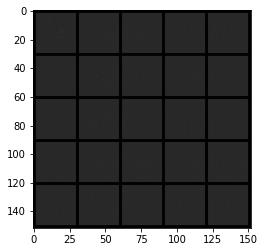

After 0 epochs


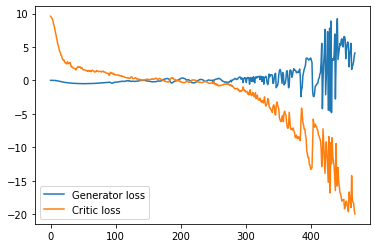

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


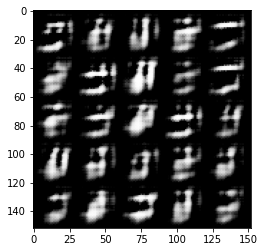

After 5 epochs


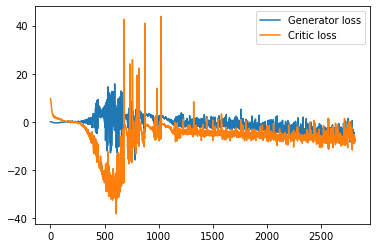

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


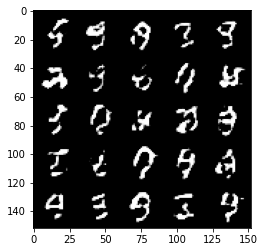

After 10 epochs


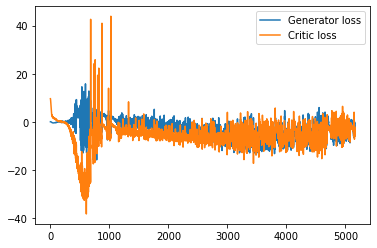

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


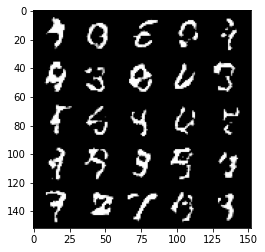

After 15 epochs


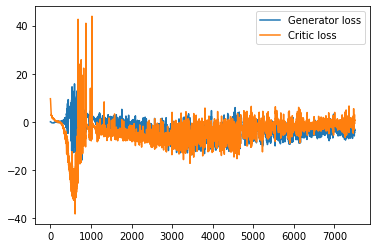

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


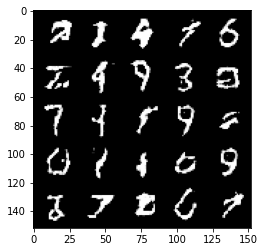

After 20 epochs


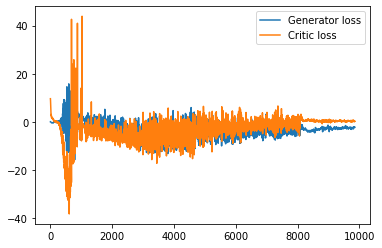

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


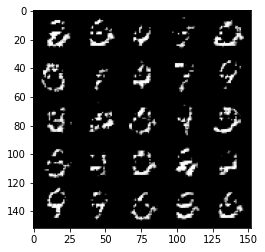

After 25 epochs


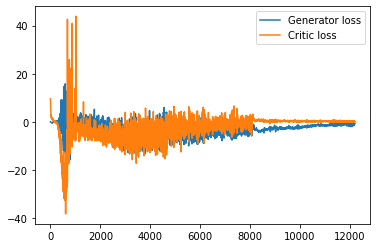

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


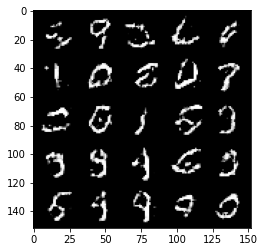

After 30 epochs


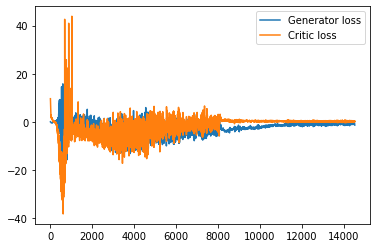

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


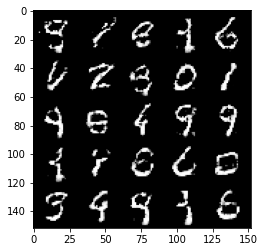

After 35 epochs


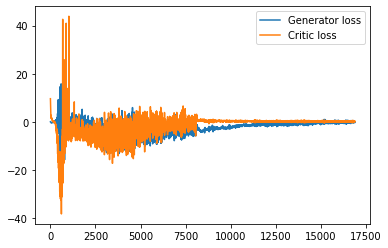

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


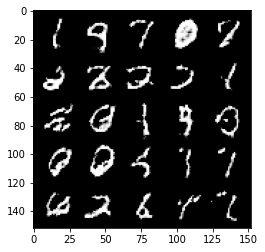

After 40 epochs


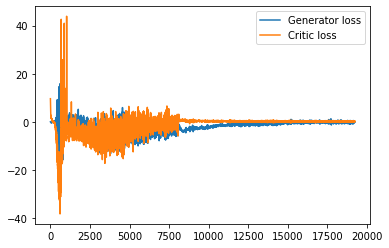

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


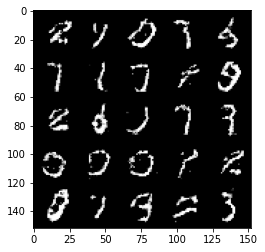

After 45 epochs


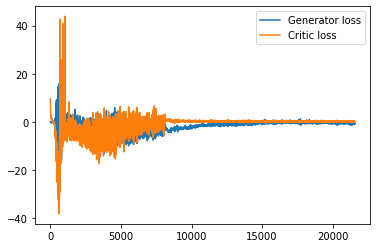

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


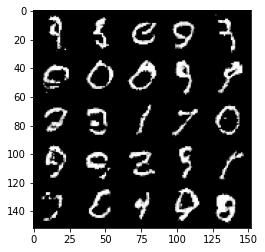

In [10]:
train(dataloader, N_EPOCHS, CRIT_REPEAT, C_LAMBDA, DISPLAY_STEP)

  0%|          | 0/30 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


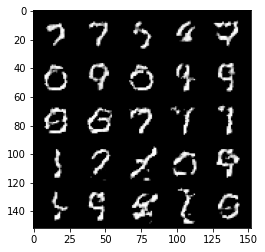

After 0 epochs


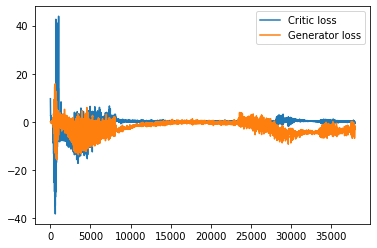

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


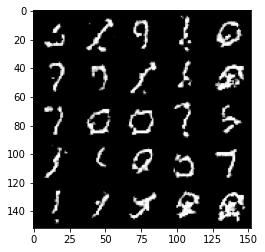

After 5 epochs


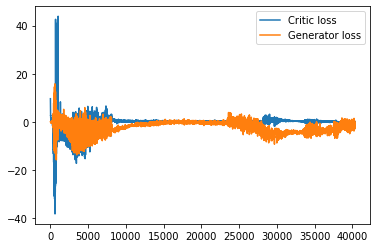

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


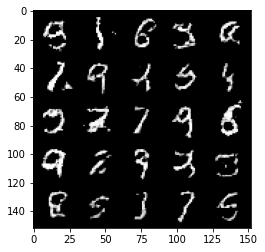

After 10 epochs


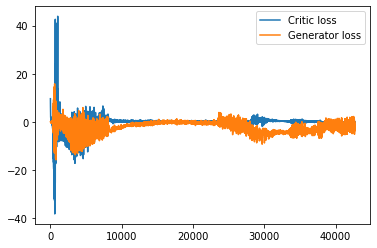

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


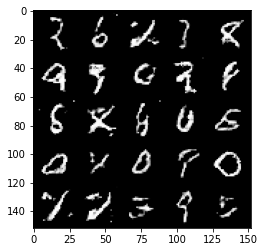

After 15 epochs


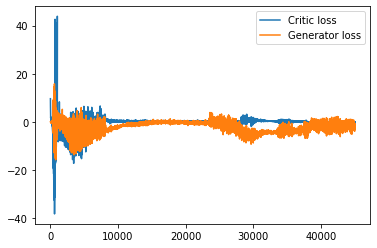

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


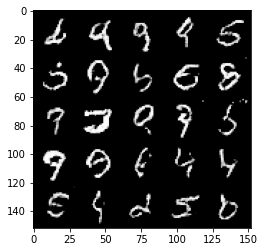

After 20 epochs


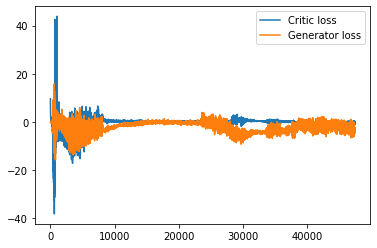

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


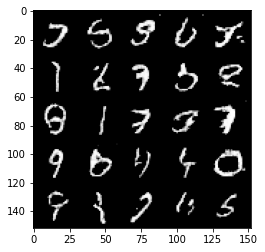

After 25 epochs


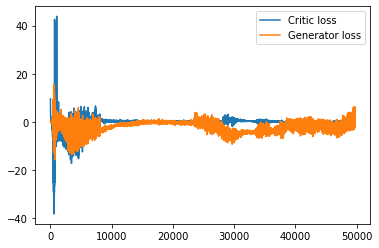

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


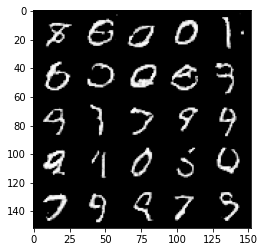

In [14]:
train(dataloader, 30, CRIT_REPEAT, C_LAMBDA, DISPLAY_STEP)